## CLASSIFICATION: UNCLASSIFIED

# Variational Autoencoder

We illustrate variational autoencoders (VAE) with the MNIST digits dataset.
Recall that with an autoencoder, the input (such as images) are mapped down
to a lower dimensional representation (encoder) and back to an approximation
of the input (reconstruction).

With VAE, the model actually learns the parameters of a probability distribution of 
a model of the data. Thus, we can make 3 models:

* an autoencoder (end-to-end from input to reconstruction)
* an encoder (from input to space of parameters)
* a generator (from the space of parameters to reconstruction)


In [1]:
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Layer
from keras import backend as K
from keras.metrics import binary_crossentropy

from scipy.stats import norm
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


Using Theano backend.


## Read the data

There are 60,000 images in the training set, 10,000 in the test set.


In [2]:
## load the pickle file with the data already divided as train/test sets

import get_data
get_data.get_file("mnist.pkl", "../data/")

with open('../data/mnist.pkl','rb') as infile:
    U = pickle._Unpickler(infile)
    U.encoding = 'latin1'
    (x_train,y_train), (x_test,y_test) = U.load()

## format
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


## VAE parameters

We use Keras to build the following VAE models with the following dimensions:
    
* input dimension (images): 784
* dimension of the hidden layer: 128
* latent dimension (parameters of the distribution): 2


In [3]:
## VAE parameters
input_dim = 784
hidden_dim = 256
latent_dim = 2
batches = 100
epochs = 50


## VAE: Encoder

* Input layer: each 784-dim image, in batches
* Hidden layer: dense; mapping to 256-dim
* Latent layer: parameters of the distribution (2-dim, dense layer)

The encoder maps the input vectors into parameters in the latent space: ($\mu,s$) 
with $s = 2 \log(\sigma)$.
We can then sample this distribution as follows:
$ z = \mu + \exp(s/2) \cdot \epsilon $
where $\epsilon$ is drawn from a standard normal. 
This is equivalent to sampling from a normal distribution with parameters $(\mu, \sigma)$.

The decoder (see below) maps $z$ back to a reconstructed input.

In [4]:
## layers for encoding
input_layer  = Input(batch_shape=(batches, input_dim))
hidden_layer = Dense(hidden_dim, activation='relu')(input_layer)
latent_layer_mean = Dense(latent_dim)(hidden_layer)     ## 'mu'
latent_layer_logsig = Dense(latent_dim)(hidden_layer)   ## 's'

## encoder model
encoder = Model(input_layer, latent_layer_mean)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (100, 784)                0         
_________________________________________________________________
dense_1 (Dense)              (100, 256)                200960    
_________________________________________________________________
dense_2 (Dense)              (100, 2)                  514       
Total params: 201,474.0
Trainable params: 201,474.0
Non-trainable params: 0.0
_________________________________________________________________


## Sampler

For the decoder and generator, we need to define how to sample from the parameters
in the latent space. Lambda() can be used to wrap arbitrary functions in a Layer object.


In [5]:
## Sampler
def sampling(args):
    mean, logsig = args
    epsilon = K.random_normal(shape=(batches,latent_dim)) ## std normal
    return mean+K.exp(logsig/2)*epsilon
## define as a Lambda layer
sample_layer = Lambda(sampling, output_shape=(latent_dim,))([latent_layer_mean,latent_layer_logsig])


## VAE: Decoder and overall model

In [6]:
## Define the decoder
decoder_h = Dense(hidden_dim, activation='relu')    ## 'hidden' layer
hidden_decoded_layer = decoder_h(sample_layer)

decoder_f = Dense(input_dim, activation='sigmoid')  ## final, reconstructed layer
final_decoded_layer = decoder_f(hidden_decoded_layer)

## Overall VAE model
vae = Model(input_layer , final_decoded_layer)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (100, 784)            0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (100, 256)            200960                                       
____________________________________________________________________________________________________
dense_2 (Dense)                  (100, 2)              514                                          
____________________________________________________________________________________________________
dense_3 (Dense)                  (100, 2)              514                                          
___________________________________________________________________________________________

## Generator model

We use the layers defined in the decoder part of the VAE to define a generator model.

In [7]:
## Generator Model
gen_input_layer = Input(shape=(latent_dim,))
gen_hidden_layer = decoder_h(gen_input_layer)
gen_final_layer = decoder_f(gen_hidden_layer)
generator = Model(gen_input_layer, gen_final_layer)
generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              multiple                  768       
_________________________________________________________________
dense_5 (Dense)              multiple                  201488    
Total params: 202,256.0
Trainable params: 202,256.0
Non-trainable params: 0.0
_________________________________________________________________


## Loss function

We build our own loss function to learn the layers in the VAE model by merging two loss functions:
    
* reconstruction loss (binary cross-entropy), which forces the final, decoded output to match the input;
* KL divergence between the learned latent distribution and the prior

The KL loss acts as a regularizer term in the overall loss function. It stems from the fact that the KL divergence between $q \sim N(\mu_1, \sigma_1^2)$ and $p \sim N(\mu_2, \sigma_2^2)$ is:
$$ 
KL(q||p) = \log\left(\frac{\sigma_2}{\sigma_1}\right) + \frac{\sigma_1^2 + (\mu_1-\mu_2)^2}{2 \sigma_2^2} - \frac{1}{2}
$$
In our case, we take the simple prior $p \sim N(0,1)$ which yields:
$$
KL(q||p) = -\frac{1}{2} \left( 1+\log(\sigma^2) - \sigma^2 - \mu^2 \right).
$$


In [8]:
## loss function
def vae_loss(x_in, x_out):
    ent_loss = input_dim * binary_crossentropy(x_in, x_out)
    kl_loss  = -0.5*K.sum(1+latent_layer_logsig-K.square(latent_layer_mean)-K.exp(latent_layer_logsig),axis=-1)
    return K.mean(ent_loss + kl_loss)
vae.compile(optimizer='rmsprop', loss=vae_loss)

## Fit the model

Learn the weights .. or load them from file.

In [9]:
#vae.fit(x_train, x_train, epochs=epochs, batch_size=batches, validation_data=(x_test, x_test))
#vae.save_weights('vae.hdf5')
vae.load_weights('vae.hdf5')

## Test set encoding

We encode the 10,000 images in the test set. Since we know the labels, we use those as color codes.
We see for example that 4's and 9's (green, grey) are quite closely related, while digits like 0, 1 and 7 
are more distinct.


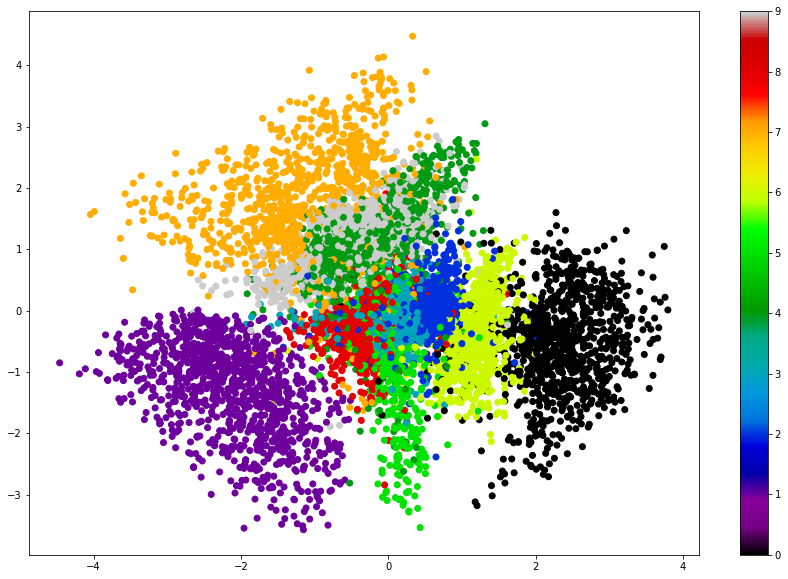

In [10]:
x_test_encoded = encoder.predict(x_test, batch_size=batches)
plt.figure(figsize=(15,10))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='nipy_spectral')
plt.colorbar()
plt.show()

## Viz the latent space

We visualize the latent space by building a grid of (x,y) values from the inverse cfd of a Gaussian
distribution, and generating an image at each of those grid points.


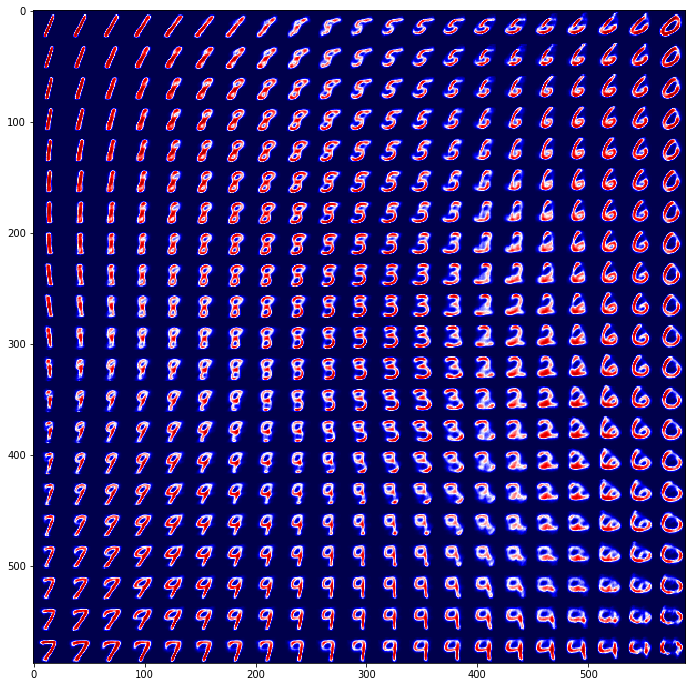

In [11]:
## use the generator
n = 21
digit_size = 28
figure = np.zeros((digit_size*n,digit_size*n))
## sample n points: use inverse cdf (ppf) of Gaussian as priors is Gaussian 
grid_x = norm.ppf(np.linspace(0.025, 0.975,n))
grid_y = norm.ppf(np.linspace(0.025, 0.975,n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size,digit_size)
        figure[i*digit_size:(i+1)*digit_size , j*digit_size: (j+1)*digit_size]=digit
plt.figure(figsize=(12,12))
plt.imshow(figure,cmap='seismic')
plt.show()
